In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
import tqdm
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import os

modelname="4_26_23_m1"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_dim: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 n_classes: int):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, embedding_dim)
        #Positional encoding
        self.pos_encode = PositionalEncoding(embedding_dim)

        self.decoder_layers = []

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(embedding_dim, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))
            #Add a feed forward
            layer.append(nn.Linear(embedding_dim, embedding_dim))
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))

            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(embedding_dim, n_classes)
            
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_ff = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_2(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
def tokenize_multi(text_seq: str, features: int, encoding = "utf8") -> torch.Tensor:
    # tokenize the input text
    sentences = []
    for sentence in filter(lambda x: x!="", text_seq.split("\n")):
        base = list(bytes(sentence, "utf8"))
        if len(base) < features:
            base.extend([0] * (features - len(base)))
        tensor = torch.Tensor(base)
        tensor = tensor.unsqueeze(0)
        sentences.append(tensor)

    return torch.cat(sentences, dim = 0)

def tokenize_single(sentence: str, features: int, encoding = "utf8") -> torch.Tensor:
    base = list(bytes(sentence, "utf8"))
    if len(base) < features:
        base.extend([0] * (features - len(base)))
    tensor = torch.Tensor(base)
    return tensor

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], features):
        self.raw_data = data
        self.features = features
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return tokenize_single(self.raw_data[index], self.features)

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode()

In [14]:
n_features = 256 # No. of tokens
n_pad = 1024 # Max line length
embedding_dim = 384
batch_size = 16
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
n_layers = 16

In [15]:
path_to_data = "data/reddit_scrape.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\n")))
random.shuffle(data_split)

train_data = data_split[100:]
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

In [16]:
model = Transformer(embedding_dim, head_size, n_features, n_layers, 256)
model=model.to(device)

In [17]:
input=next(testloader_iter)
input=input.to(device)
res = model(input)
print(input.shape)
print(res.shape)
print(res.argmax(-1))

torch.Size([1, 1024])
torch.Size([1, 1024, 256])
tensor([[  3, 117, 104,  ...,  53,  53,  53]], device='cuda:0')


In [18]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
n_epochs = 40

In [20]:
!nvidia-smi

Wed Apr 26 12:15:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   48C    P0    62W / 150W |   1855MiB / 23028MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
print(device)

cuda


In [22]:
prompts = [
    "Why does Earth orbit the Sun?",
    "How to use ChatGPT?",
    "My code does not work. What should I do?",
    "Why is this code not working: `1+\"A\"`?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C?",
    "What is coding?",
]

Epoch 1


100%|██████████| 8060/8060 [1:42:56<00:00,  1.30it/s]


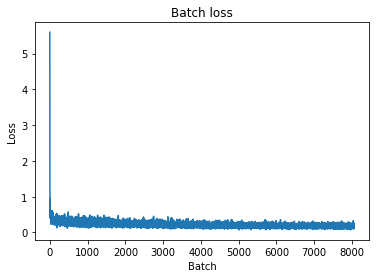

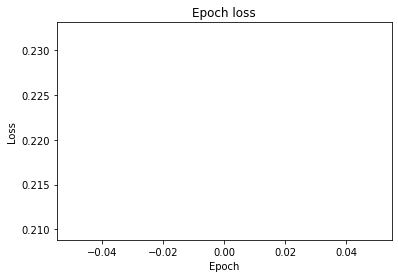

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun? I want to get the static that the same the same the same that the constructor and the statement the statistical the are the same the and the test to the statement the statistical the and the statistical the an entire the tornation the statistical the and the torgeth the statistical the statistical the and the torger the statical the statistical the and the tord the tord the torn the topical the torn the to the topical the tory to the topical the topical the to the tory any the ton the topperan the are any any the any and the the tole the to the the tore the tolly the the ton the the tolly the the ton the the ton the the the ton the the ton the the ton the the the ton the the ton the the the ton the the the ton the the ton the the the ton the the ton the the the the ton the ton the the ton the the the the the the ton t ton the ton the the the the the ton the the the then t then ton the t the the ton the 

100%|██████████| 8060/8060 [1:44:18<00:00,  1.29it/s]


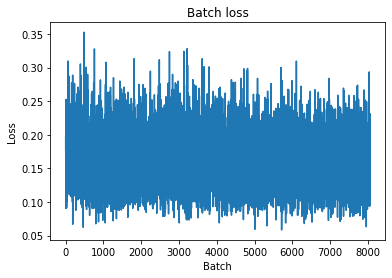

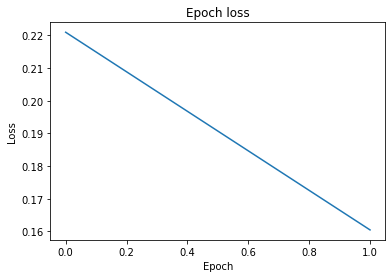

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun? I want to do this a bit of the same that I want to do the same the same that I was wondering a lot of the same that I was wondering the same that the same thing the same that the same the same thing the same that the constructor and the same the same that the constructor that the constructor the same the constructor that the constructor the constructor that the same the same the same that the constructor the constructor the constructors. I wand the constructor the constructors the constructors the constructors the constines the constructing the the contentine the the the conss the the the the the conss the the the the the the the the the the the therm the the the the the the thesp the the thesp the the than the the thend the than the the then then than the thend than the thend the thand the than thend thend then then thend thend then than then than than theng than t thand thang thang t thand thang thang

  6%|▋         | 505/8060 [06:29<1:37:03,  1.30it/s]


KeyboardInterrupt: 

In [23]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
    
    
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            print(f"Model output: {output}")
            print()



In [ ]:
model = torch.load(prefix_models+"model_E9")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()